In [1]:
!pip install kagglehub


In [2]:
import kagglehub
import pandas as pd
import os

path = kagglehub.dataset_download(
    "bhanupratapbiswas/titanic-survival-datasets"
)
print(path)


100%|██████████| 11.2k/11.2k [00:00<00:00, 6.73MB/s]

Extracting files...
/root/.cache/kagglehub/datasets/bhanupratapbiswas/titanic-survival-datasets/versions/1


In [3]:
os.listdir(path)


['titanic.csv']

In [6]:
df = pd.read_csv(os.path.join(path, "titanic.csv"))
df.head()

PassengerId  Survived  Pclass  \
0          892         0       3   
1          893         1       3   
2          894         0       2   
3          895         0       3   
4          896         1       3   

                                           Name     Sex   Age  SibSp  Parch  \
0                              Kelly, Mr. James    male  34.5      0      0   
1              Wilkes, Mrs. James (Ellen Needs)  female  47.0      1      0   
2                     Myles, Mr. Thomas Francis    male  62.0      0      0   
3                              Wirz, Mr. Albert    male  27.0      0      0   
4  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female  22.0      1      1   

    Ticket     Fare Cabin Embarked  
0   330911   7.8292   NaN        Q  
1   363272   7.0000   NaN        S  
2   240276   9.6875   NaN        Q  
3   315154   8.6625   NaN        S  
4  3101298  12.2875   NaN        S

In [7]:
df.shape


(418, 12)

In [8]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Survived     418 non-null    int64  
 2   Pclass       418 non-null    int64  
 3   Name         418 non-null    object 
 4   Sex          418 non-null    object 
 5   Age          332 non-null    float64
 6   SibSp        418 non-null    int64  
 7   Parch        418 non-null    int64  
 8   Ticket       418 non-null    object 
 9   Fare         417 non-null    float64
 10  Cabin        91 non-null     object 
 11  Embarked     418 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 39.3+ KB


In [9]:
df.isnull().sum()


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

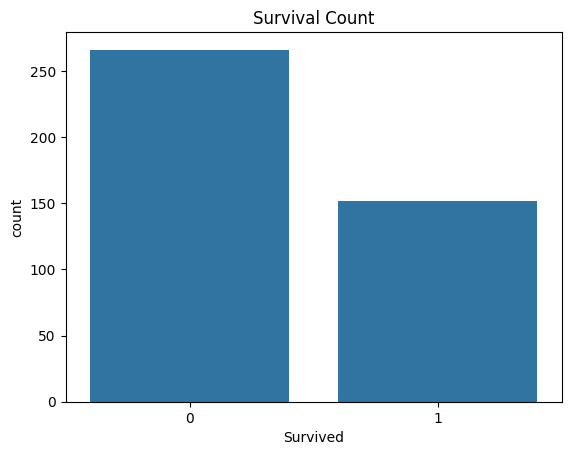

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='Survived', data=df)
plt.title("Survival Count")
plt.show()


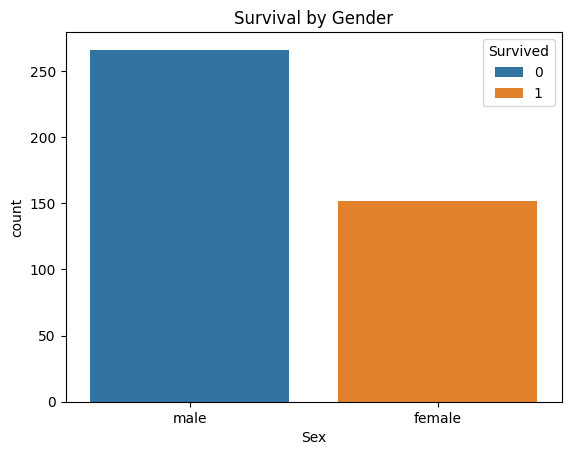

In [11]:
sns.countplot(x='Sex', hue='Survived', data=df)
plt.title("Survival by Gender")
plt.show()


Feature Engineering

In [12]:
df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

df['Title'].value_counts()


<>:1: SyntaxWarning: invalid escape sequence '\.'
<>:1: SyntaxWarning: invalid escape sequence '\.'
/tmp/ipython-input-210977696.py:1: SyntaxWarning: invalid escape sequence '\.'
  df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)


Title
Mr        240
Miss       78
Mrs        72
Master     21
Col         2
Rev         2
Ms          1
Dr          1
Dona        1
Name: count, dtype: int64

In [13]:
df['Title'] = df['Title'].replace(
    ['Lady','Countess','Capt','Col','Don','Dr','Major',
     'Rev','Sir','Jonkheer','Dona'], 'Rare'
)

df['Title'] = df['Title'].replace({'Mlle':'Miss','Ms':'Miss','Mme':'Mrs'})


In [14]:
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1


In [15]:
df['HasCabin'] = df['Cabin'].notnull().astype(int)


Handle Missing Values

In [16]:
df['Age'] = df.groupby('Title')['Age'].transform(
    lambda x: x.fillna(x.median())
)


In [17]:
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)


/tmp/ipython-input-411043493.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)


Drop Unnecessary Columns

In [18]:
df.drop(columns=['PassengerId','Name','Ticket','Cabin'], inplace=True)


Encode Categorical Variables

In [19]:
df_encoded = pd.get_dummies(df, drop_first=True)
df_encoded.head()


Survived  Pclass   Age  SibSp  Parch     Fare  FamilySize  HasCabin  \
0         0       3  34.5      0      0   7.8292           1         0   
1         1       3  47.0      1      0   7.0000           2         0   
2         0       2  62.0      0      0   9.6875           1         0   
3         0       3  27.0      0      0   8.6625           1         0   
4         1       3  22.0      1      1  12.2875           3         0   

   Sex_male  Embarked_Q  Embarked_S  Title_Miss  Title_Mr  Title_Mrs  \
0      True        True       False       False      True      False   
1     False       False        True       False     False       True   
2      True        True       False       False      True      False   
3      True       False        True       False      True      False   
4     False       False        True       False     False       True   

   Title_Rare  
0       False  
1       False  
2       False  
3       False  
4       False

Feature–Target Split

In [20]:
X = df_encoded.drop(columns=['Survived'])
y = df_encoded['Survived']


In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


#Train Models

Logistic Regression

In [25]:
from sklearn.linear_model import LogisticRegression

# Fill NaN in 'Fare' column of X_train and X_test
# Calculate median from X_train to avoid data leakage
fare_median = X_train['Fare'].median()
X_train['Fare'] = X_train['Fare'].fillna(fare_median)
X_test['Fare'] = X_test['Fare'].fillna(fare_median)

lr = LogisticRegression(max_iter=300)
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)

Random Forest

In [24]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)


Evaluation Metrics

In [26]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def evaluate(name, y_true, y_pred):
    print(f"\n{name}")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("Classification Report:\n", classification_report(y_true, y_pred))


In [28]:
evaluate('Logistic Regression', y_test, lr_pred)
evaluate('Random Forest', y_test, rf_pred)


Logistic Regression
Accuracy: 1.0
Confusion Matrix:
 [[53  0]
 [ 0 31]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        53
           1       1.00      1.00      1.00        31

    accuracy                           1.00        84
   macro avg       1.00      1.00      1.00        84
weighted avg       1.00      1.00      1.00        84


Random Forest
Accuracy: 1.0
Confusion Matrix:
 [[53  0]
 [ 0 31]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        53
           1       1.00      1.00      1.00        31

    accuracy                           1.00        84
   macro avg       1.00      1.00      1.00        84
weighted avg       1.00      1.00      1.00        84



Model Explainability

In [29]:
importances = pd.Series(rf.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).head(10)


Sex_male      0.419689
Title_Mr      0.262205
Title_Miss    0.152076
Title_Mrs     0.087940
Age           0.023341
Fare          0.012493
FamilySize    0.011189
Parch         0.008445
SibSp         0.006260
Pclass        0.005066
dtype: float64

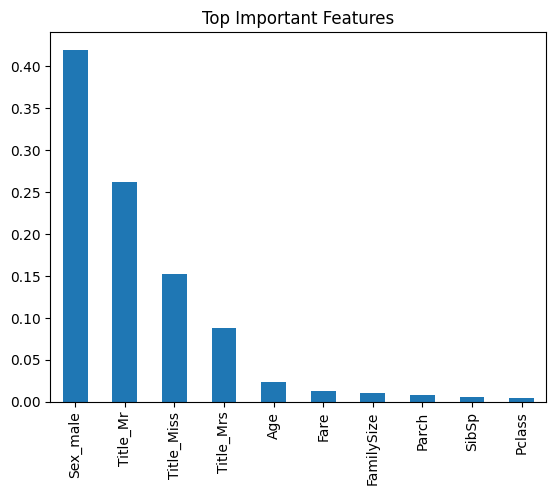

In [30]:
importances.sort_values(ascending=False).head(10).plot(kind='bar')
plt.title("Top Important Features")
plt.show()


save best model

In [31]:
import joblib

joblib.dump(rf, "titanic_model.pkl")


['titanic_model.pkl']

Inference Example

In [32]:
model = joblib.load("titanic_model.pkl")

sample = X.iloc[0:1]
prediction = model.predict(sample)

print("Survived (1=Yes, 0=No):", prediction[0])


Survived (1=Yes, 0=No): 0
